In [22]:
import pandas as pd
import numpy as np

from run_backtest import load_trackers
from utils import clean_stale_prices

from entities import EM_CDS_TRACKER_DICT, FX_TRACKER_DICT
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

In [76]:
def plot_bar_contribution(
    heights: pd.Series,
    title: str,
):
    plt.figure(figsize=(10, 6))
    cumulative_values = np.cumsum(heights) - heights
    plt.bar(
        range(1, len(heights) + 1),
        heights,
        bottom=cumulative_values,
        alpha=0.5,
        align="center",
        label="Explained Variance",
    )

    plt.ylim(0, 1)
    plt.xlabel("Componente Principal", labelpad=10)
    plt.ylabel("Explicação da Variância", labelpad=10)
    plt.title(title, fontweight="bold", pad=20)

    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.75)
    plt.grid(True, which="minor", axis="x", linestyle="--", linewidth=0.75)

    plt.gca().tick_params(axis="x", which="both", length=0)

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    plt.xticks(range(1, len(heights) + 1))
    plt.tight_layout()
    plt.show()


def plot_historical_correlation(rolling_corr: pd.Series, total_correlation: float):
    plt.figure(figsize=(10, 6))
    rolling_corr.plot()
    plt.axhline(
        total_correlation,
        color="red",
        linestyle="--",
        label="Correlação Média do Período",
    )
    plt.grid(True, which="both", axis="both", linestyle="--", linewidth=0.75)
    plt.xlabel(None)
    plt.xlim(rolling_corr.dropna().index.min(), rolling_corr.index.max())
    plt.ylim(0, 1)
    plt.legend(ncol=2)
    plt.title(
        "Correlação entre a Primeira Componente Principal de FX e a de CDS",
        fontweight="bold",
        pad=20,
    )
    plt.tight_layout()
    plt.show()

In [2]:
cds = load_trackers(EM_CDS_TRACKER_DICT).rename(columns=lambda col: col + "_cds")
fx = load_trackers(FX_TRACKER_DICT).rename(columns=lambda col: col + "_fx")

cds = pd.concat([clean_stale_prices(cds[col].copy()) for col in cds], axis=1)
fx = pd.concat([clean_stale_prices(fx[col].copy()) for col in fx], axis=1)

In [ ]:
RETURN_WINDOW = 21

df_cds = (
    np.log(cds)
    .fillna(method="ffill", limit=5)
    .diff(RETURN_WINDOW)
    .dropna(how="all")
    .copy()
)
df_cds = df_cds.loc["2009-12-10":].dropna(how="any", axis=1)
df_cds = (df_cds - df_cds.mean())/ df_cds.std()

df_fx = (
    np.log(fx)
    .fillna(method="ffill", limit=5)
    .diff(RETURN_WINDOW)
    .dropna(how="all")
    .copy()
)
df_fx = df_fx.loc["2004-08-02":].dropna(how="any", axis=1)
df_fx = (df_fx - df_fx.mean()) / df_fx.std()

new_index = df_fx.dropna().index.intersection(df_cds.dropna().index)
df_fx = df_fx.reindex(new_index)
df_cds = df_cds.reindex(new_index)

df_all = pd.concat([df_cds, df_fx], axis=1).dropna()
df_all

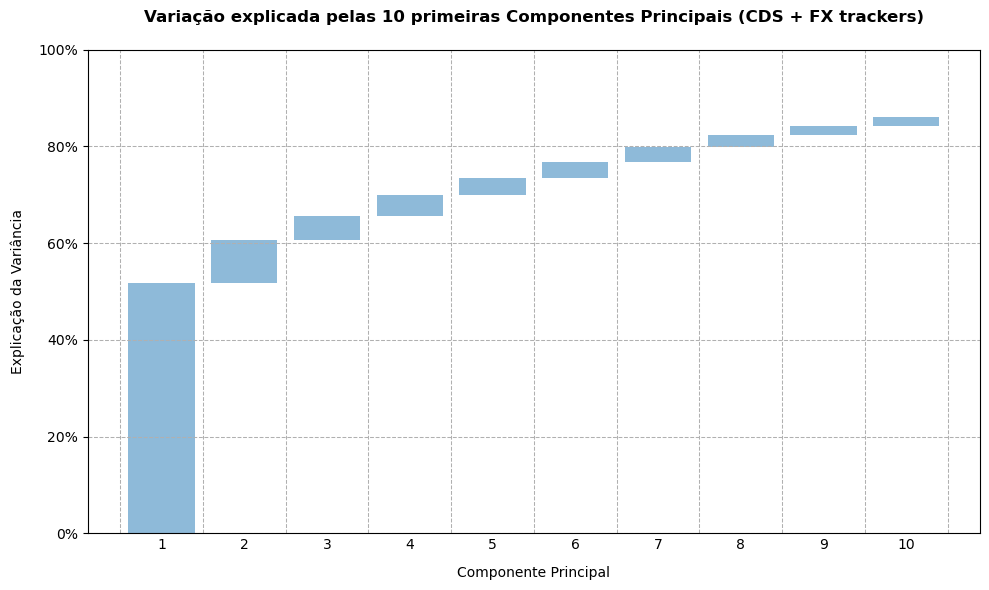

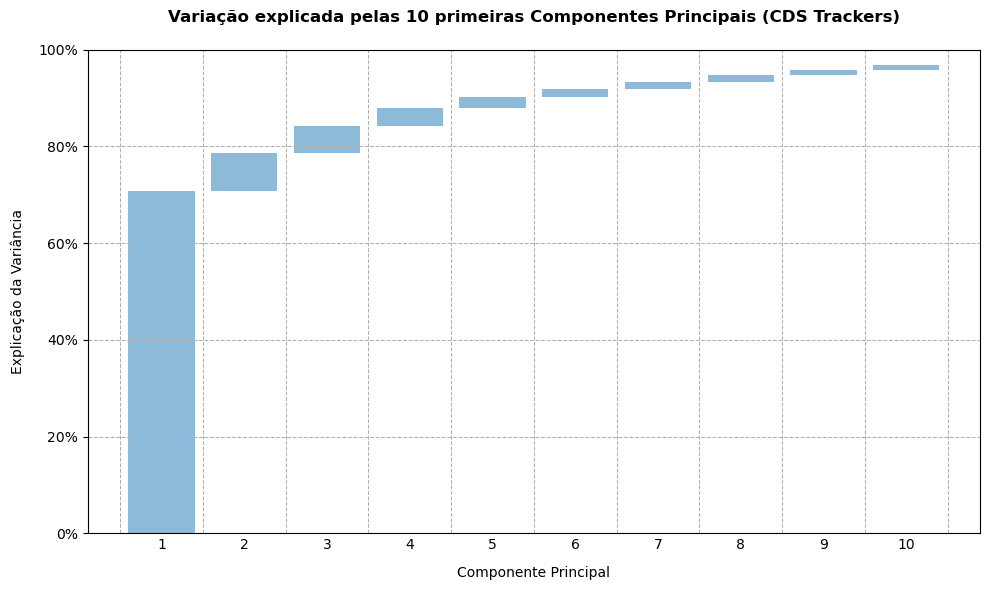

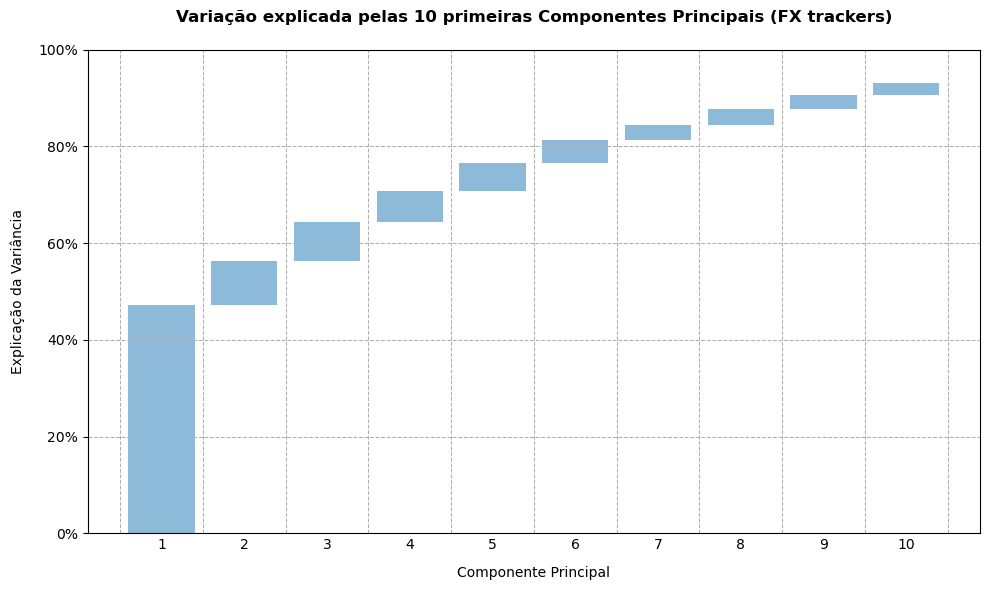

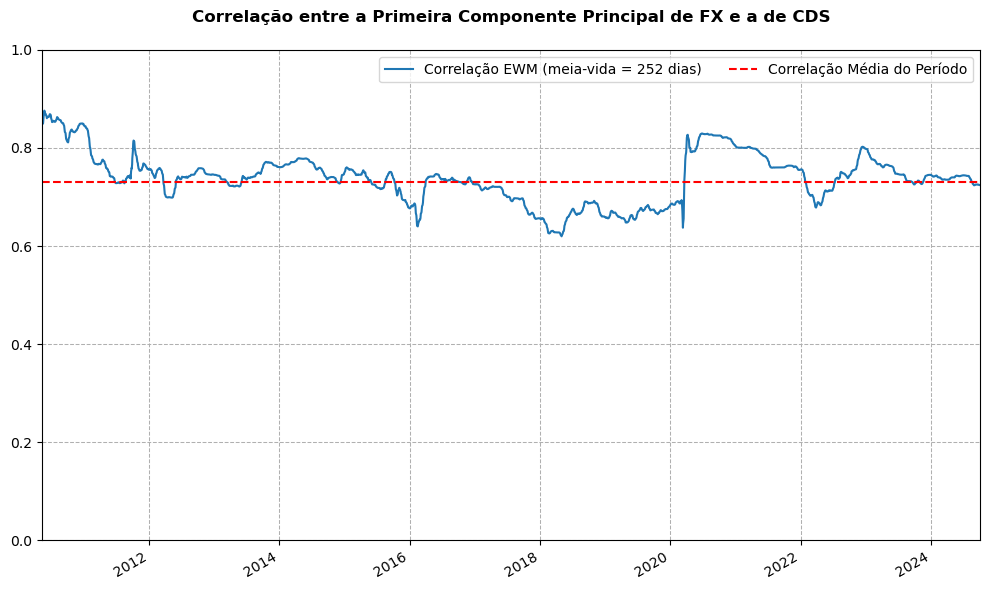

In [78]:
pca_all = PCA(n_components=10).fit(df_all)
plot_bar_contribution(
    pca_all.explained_variance_ratio_,
    "Variação explicada pelas 10 primeiras Componentes Principais (CDS + FX trackers)",
)
pca_cds = PCA(n_components=10).fit(df_cds.dropna())
explained_variance_ratio = pca_cds.explained_variance_ratio_
plot_bar_contribution(
    pca_cds.explained_variance_ratio_,
    "Variação explicada pelas 10 primeiras Componentes Principais (CDS Trackers)",
)
pca_fx = PCA(n_components=10).fit(df_fx.dropna())
explained_variance_ratio = pca_fx.explained_variance_ratio_
plot_bar_contribution(
    pca_fx.explained_variance_ratio_,
    "Variação explicada pelas 10 primeiras Componentes Principais (FX trackers)",
)

pca_1_fx = pd.DataFrame(pca_fx.fit_transform(df_fx), index=new_index).iloc[:, 0]
pca_1_cds = pd.DataFrame(pca_cds.fit_transform(df_cds), index=new_index).iloc[:, 0]

plot_historical_correlation(
    pca_1_cds.ewm(halflife=252)
    .corr(pca_1_fx)
    .iloc[100:]
    .rename("Correlação EWM (meia-vida = 252 dias)"),
    pca_1_cds.corr(pca_1_fx),
)

# OLD

In [42]:
from scipy import stats
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(pca_1_cds, pca_1_fx)

# r_value is the correlation coefficient, so R² is r_value squared
r_squared = r_value**2

print(f"R²: {r_squared}")

R²: 0.5335699538230672


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_1_cds, pca_1_fx.reindex(pca_1_cds.index))
plt.title("Scatter plot of Expanding Correlation between PCA1 CDS and PCA1 FX")
plt.xlabel("Date")
plt.ylabel("Expanding Correlation")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()